Initialize the environment

In [1]:
import torch
print(torch.backends.mps.is_available())  # Should print True
print(torch.backends.mps.is_built())

True
True


In [2]:
from TamGen_custom import TamGenCustom, prepare_pdb_data
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

worker = TamGenCustom(
    data="./TamGen_Demo_Data",
    ckpt="checkpoints/crossdock_pdb_A10/checkpoint_best.pt",
    use_conditional=True
)

Namespace(no_progress_bar=False, log_interval=1000, log_format=None, tensorboard_logdir='', tbmf_wrapper=False, seed=1, cpu=False, fp16=False, memory_efficient_fp16=False, fp16_init_scale=128, fp16_scale_window=None, fp16_scale_tolerance=0.0, min_loss_scale=0.0001, threshold_loss_scale=None, user_dir=None, criterion='cross_entropy', tokenizer=None, bpe=None, optimizer='nag', lr_scheduler='fixed', task='translation_coord', num_workers=1, skip_invalid_size_inputs_valid_test=False, max_tokens=1024, max_sentences=None, required_batch_size_multiple=8, dataset_impl=None, gen_subset='gen_8fln', num_shards=1, shard_id=0, path='checkpoints/crossdock_pdb_A10/checkpoint_best.pt', remove_bpe=None, quiet=False, model_overrides='{}', results_path=None, beam=20, nbest=20, max_len_a=0, max_len_b=200, min_len=1, match_source_len=False, no_early_stop=False, unnormalized=False, no_beamable_mm=False, lenpen=1, unkpen=0, replace_unk=None, sacrebleu=False, score_reference=False, prefix_size=0, prefix_string

Set the PDB you want to generate cmpds

In [14]:
pdb_id = "5ool" # "5dzk, 7d1m" "7te0"
prepare_pdb_data(pdb_id)

5ool is downloaded


In [4]:
worker.reload_data(subset="gen_" + pdb_id.lower())

hyps, ref = worker.sample(
    m_sample=5000, 
    maxseed=30,
)

| loaded 1 examples from: ./TamGen_Demo_Data/gen_5ool.tg-m1.tg
| loaded 1 examples from: ./TamGen_Demo_Data/gen_5ool.tg-m1.m1
| ./TamGen_Demo_Data gen_5ool tg-m1 1 examples
| loaded 1 examples from: ./TamGen_Demo_Data/gen_5ool.tg-m1.tg.coord


 97%|█████████▋| 29/30 [05:02<00:10, 10.44s/it]


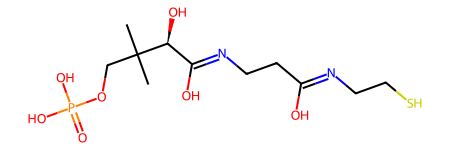

In [6]:
ref

Visualize the molecules

In [8]:
from rdkit import Chem 
from rdkit.Chem import Draw, AllChem, DataStructs
from rdkit.Chem import MACCSkeys

fp_ref = MACCSkeys.GenMACCSKeys(ref)

gens = []

for k,v in hyps.items():
    fp = MACCSkeys.GenMACCSKeys(v)
    similarity = DataStructs.FingerprintSimilarity(fp_ref, fp, metric=DataStructs.TanimotoSimilarity)
    gens.append((v,k, similarity))

sorted_gen = sorted(gens, key=lambda e: e[-1], reverse=True)

/opt/anaconda3/envs/TamGen/lib/python3.12/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


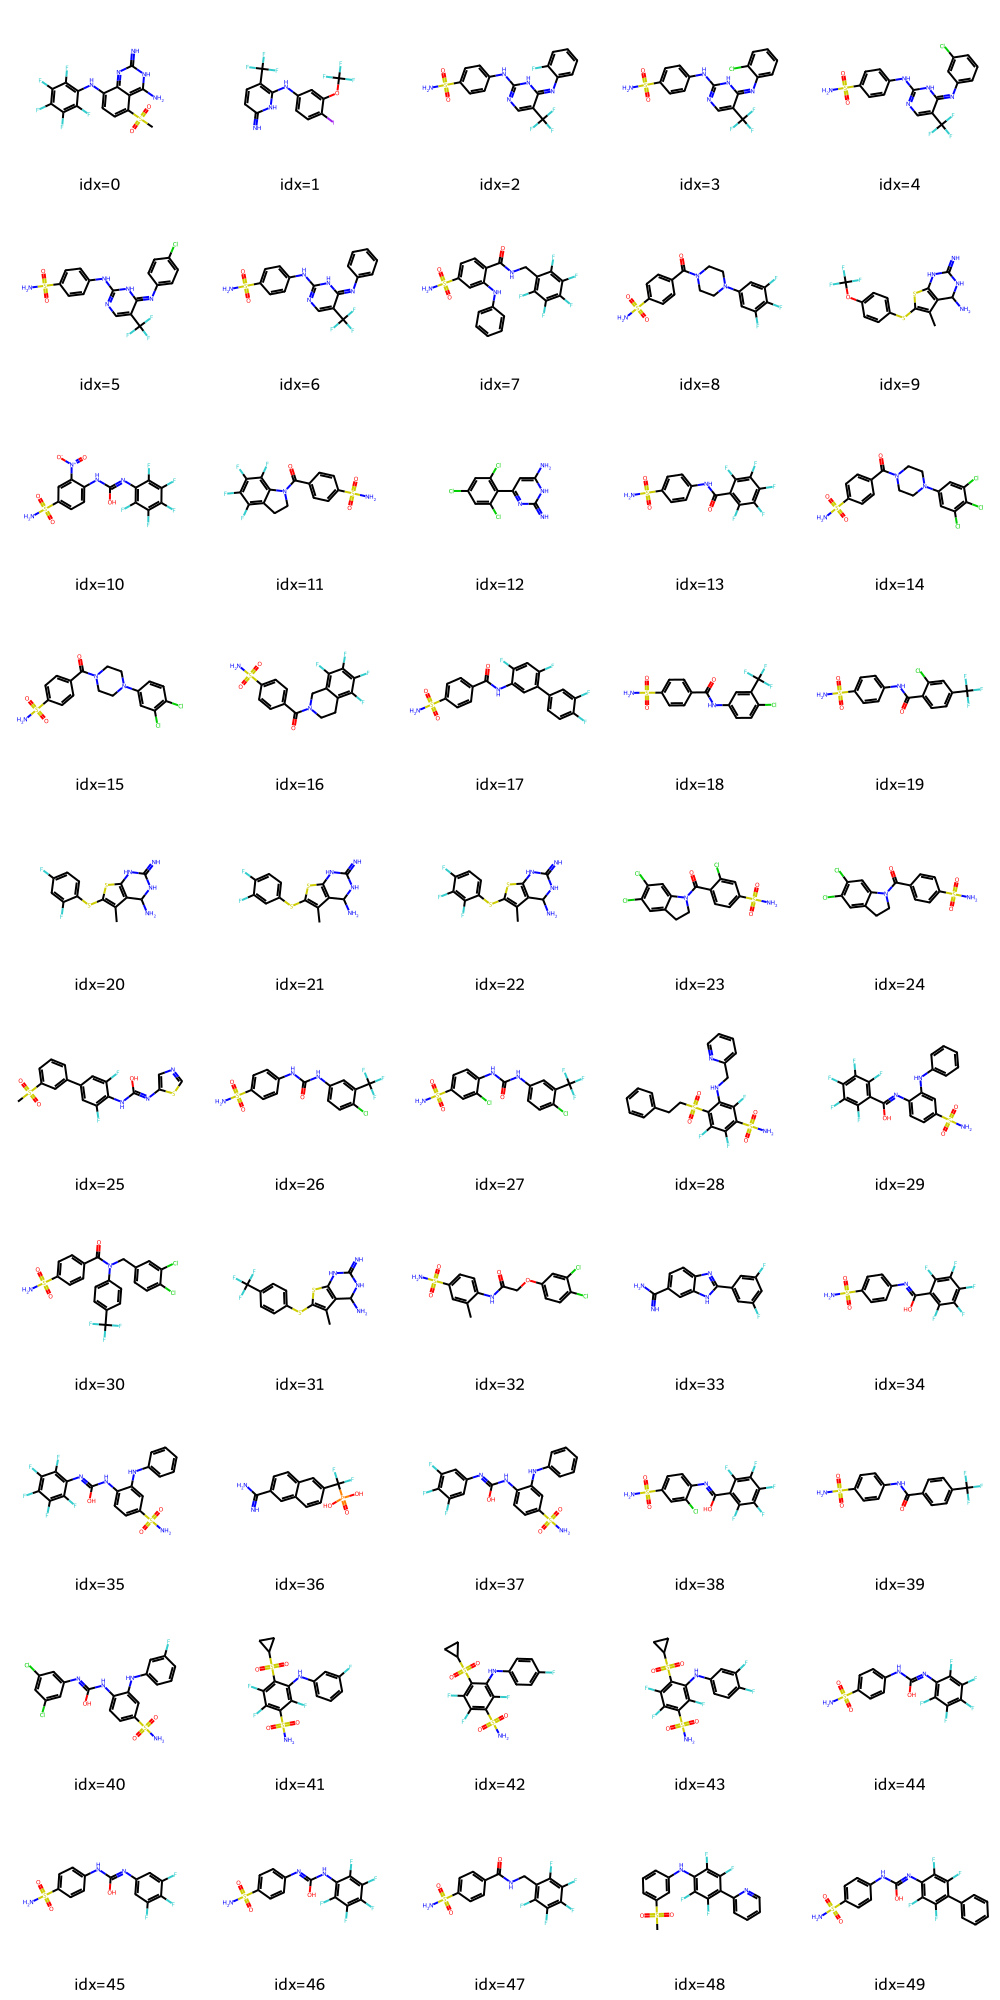

In [18]:
# img=Draw.MolsToGridImage([e[0] for e in sorted_gen], molsPerRow=5, legends=["idx={}, morgan={:.2f}".format(ii, e[2]) for ii, e in enumerate(sorted_gen)])
img=Draw.MolsToGridImage([e[0] for e in sorted_gen], molsPerRow=5, legends=["idx={}".format(ii) for ii in range(len(sorted_gen))])
img

In [4]:
from Bio.PDB import MMCIFParser

def get_amino_acid_sequence(pdb_id):    
    """
    Extracts amino acid sequences from a given PDB structure file in CIF format.

    Args:
        pdb_id (str): pdb id of the protein.

    Returns:
        dict: A dictionary where keys are chain IDs and values are amino acid sequences.
    """

    cif_file_path = f"./database/PDBlib/{pdb_id.lower()}.cif"

    parser = MMCIFParser(QUIET=True)
    structure = parser.get_structure("protein", cif_file_path)
    
    sequences = {}
    for model in structure:
        for chain in model:
            seq = "".join(residue.resname for residue in chain if residue.id[0] == " ")
            sequences[chain.id] = seq 
            
    return sequences

sequences = get_amino_acid_sequence("5ool")
for chain_id, seq in sequences.items():
    print(f"Chain {chain_id}: {seq}")

Chain A: GCUAAACCUAGCCCCAAACCCCCACCUUACUACCAAACCUUAGCCAAACCAUUUACAUAAAGUAUAGGCGAUAGAAAUUGGGCGCAAUAGAUAUAGUACCGCAAGGGAAAGAUGAAAAAACCAAGCAUAAUAUAGCAAGGACUAACCCCUAUACCUUCUGCAUAAUGAAUUAACUAGAAAUAACUUUGCAAGGAGAGCCAAAGCUAAGACCCCCGAAACCAGACGAGCUACCUAAGAACAGCUAAGAGCACACCCGUCUAUGUAGCAAAAUAGUGGGAAGAUUUAUAGGUAGAGGCGACAAACCUACCGAGCCUGGUGAUAGCUGGUUGUCCAAGAUAGAAUCUUAGUUCAACUUUAAAUUUGCCCACAGAACCAAAUCCCCUUGUAAAUUUAACUGUUAGUCCAAAGAGGAACAGCUCUUUGGACACUAGGAAAAAACCUUGUAGAGAGAGUAAAAAAUUUAACACCCAUAGUAGGCCUAAAAGCAGCCACCAAUUAAGAAAGCGUUCAAGCUCAACACAAAAAUCCCAAACAUAUAACUGAACUCCUCACACCCAAUUGGACCAAUCUAUCACCCUAUAGAAGAACUAAUGUUAGUAUAAGUAACAUGAAAACAUUCUCCUCCGCAUAAGCCUGCGUCAGCAACUGACAAUUAACAGCCCAAUAUCUACAAUCAACCAACAAGUCAUUAUUACCCUCACUGUCAACCCAACACAGGCAUGCUCAUAAGGAAAGGUUAAAAAAAGUAAAAGGAACUCGGCAAAUCUUACCCCGCCUGUUUACCAAAAACAUCACCUCUAGCAUCACCAGUAUUAGAGGCACCGCCUGCCCAGUGACACAUGUUUAACGGCCGCAAAGGUAGCAUAAUCACUUGUUCCUUAAAUAGGGACCUGUAUGAAUGGCUCCACGAGGGUUCAGCUGUCUCUUACUUUUAACCAGUGAAAUUGACCUGCCCGUGAAGAGGCGGGCAUAACACAGCAAGACGAGAAGA

In [2]:
import os
print(os.path.abspath("scripts/build_data/prepare_pdb_ids.py"))
print(os.path.exists("scripts/build_data/prepare_pdb_ids.py"))

/Users/redomic/Documents/Projects/Hackathons/GDG/GDG-25/TamGen/scripts/build_data/prepare_pdb_ids.py
True
